In [1]:
# !git clone https://github.com/vincentnam/ProjetInterpromo2020G8.git

In [2]:
from abc import ABCMeta, abstractmethod
from typing import Iterable

import numpy as np
from pipeline import Process, Preprocess, Postprocess, Pipeline, overrides, MetaProcess, NotProcessClass, DistPipeline


import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from collections import defaultdict
from PIL import Image

from matplotlib import image
import matplotlib.patches as mpatches
from skimage import io
import skimage.segmentation as seg
from skimage.segmentation import clear_border
import skimage.filters as filters
from skimage.filters import threshold_otsu
import skimage.draw as draw
import skimage.color as color
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.morphology import closing, square

# Preprocessing definition

In [3]:
class ColourPipelineSeat(Preprocess):
    process_desc = "Standard Python >= 3.5 -> preprocess colours"
    
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.colour_pipeline(colours = {}, epsilon = 40, colour_mode = False, 
                            default_colour = [255, 255, 255], rgb_len = 3)
    
    
class BlackWhite(Preprocess):
    process_desc = "OpenCV4.1.2.30 -> rgb to grey"

    def run(self, **kwargs) -> Iterable:
        return self.col_obj.util_obj.to_gray() 
        
        
class ColourPipelineZones(Preprocess):
    process_desc = "Standard Python >= 3.5 -> preprocess colours"
    
    def run(self, **kwargs) -> Iterable:
        return self.col_obj.colour_pipeline(colours = {}, epsilon = 30, colour_mode = True, 
                        default_colour = [0, 0, 0], rgb_len = 3) 
    

## Processing definition

In [4]:

class PatternMatchingNormalSeat(Process):
    process_desc = "OpenCV4.1.2.30 -> pattern matching normal seat"
        
    def coord_pattern_finder(self,image, template, threshold: float):
        """
        input:
            image : image plane cv2.imread() black and white
            template : image pattern cv2.imread() black and white
            threshold : threshold for this pattern
        output:
            position : list right angle position for this pattern on the image

        """
        position = []  # Variable output
        # List of match
        res = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
        for pos in zip(*np.where(res >= threshold)[::-1]):
            position.append(pos)
        return(position)
    
    
    def run(self, image, json, image_rgb = None, col_obj = None, templates = None, data_image=None, **kwargs) -> None :
        #col_obj = Colour(data_path, layouts[0], p)
        #col_obj = Colour(data_image[0], data_image[1][0], data_image[2])
        
    # Make a colour detection based on the layout type ('GURU' or 'MAESTRO') and image type('png', 'jpg')
        img_to_show = image

        #img_rgb = image_rgb
        #img_gray = image
        #img_rgb = cv.imread(data_image, 1)
        img_gray = cv.imread(data_image, 0)
        print(data_image + ' shape', img_gray.shape)

        for template_name in templates:
            #template = cv.imread(templates_path + template_name, 0)
            
            template = cv.imread("./images/" + template_name, 0)
            if template is not None:
                h, w = template.shape
                print(template_name, h,w)

                threshold = 0.8 #  Default threshold
                # Choose threshold for each template
                if template_name == 'temp_business_seat_armrest_left.jpg':
                    threshold = 0.6
                elif template_name == 'temp_business_seat_armrest_right.jpg':
                    threshold = 0.6
                elif template_name == 'temp_business_seat_footrest.jpg':
                    threshold = 1
                elif template_name == 'temp_first_seat.jpg':
                    threshold = 1
                elif template_name == 'temp_normal_seat.png':
                    threshold = 0.7
                elif template_name == 'temp_normal_seat_elec.jpg':
                    threshold = 1
                elif template_name == 'temp_normal_seat_little.jpg':
                    threshold = 0.65
                elif template_name == 'temp_yellow_seat.jpg':
                    threshold = 1

                position = self.coord_pattern_finder(img_gray, template, threshold)

                for pos in position:
                    img_to_show = cv.rectangle(img_to_show, pos, (pos[0] + w, pos[1] + h), (0, 0, 255), 2)
                json[template_name] = position
        plt.figure(figsize=(20, 40))
        plt.imshow(img_to_show.astype('uint8'))
        print(json)

class SegmentationZone(Process):
    process_desc = "OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas"
    
    def image_process_label(self, image):
        # grayscale = rgb2gray(image)
        thresh = threshold_otsu(image)
        bw = closing(image > thresh, square(2))
        cleared = clear_border(bw)
        label_image = label(cleared)
        return label_image

    def label_results(self, image, json, data_image = None, min_rectangle_area = 80):
        # the result will be store in this list
        image_detection_result = []
        if data_image is None : 
            print("Data_image is None")
        # get the image
        
        # get the different area
        label_image = self.image_process_label(image)
        props = regionprops(label_image)

        # prepare the image info
        json[data_image.split('/')[-1]]={"areas": [], "rectangles": [],
                          "diameters": [], "coordinates": []}
#         image_detection_result.append({
#             'image_name': image_path.split('/')[-1],
#             "areas": [],
#             "rectangles": [],
#             "diameters": [],
#             "coordinates": []
#         })

        # the last index in the list
        len_list = len(image_detection_result) - 1

        # by region find every rectangle that will interesting us
        for region in props:
            # bigger enough area chosen
            if region.area >= min_rectangle_area:
                json[data_image.split('/')[-1]]['areas'].append(region['Area'])
                json[data_image.split('/')[-1]]['rectangles'].append(region['BoundingBox'])
                json[data_image.split('/')[-1]]['diameters'].append(region['EquivDiameter'])
                json[data_image.split('/')[-1]]['coordinates'].append(region['Coordinates'])

    
    
    def run(self, image, json, image_rgb = None, col_obj = None, templates = None, data_image=None, **kwargs) -> None :
        plt.imshow(image)
        plt.show()
        self.label_results(image, json, data_image)
        
        
        

# Post processing definition

In [5]:
class RemoveDouble(Postprocess):
    process_desc = "Standard Python >= 3.5 -> remove double point in list"
    
    def remove_duplicate(self,coordinate: list):
        """Documentation
        Parameters:
            coordinate: original coordinates without treatment
        Out:
            dup: list of coordinate which are duplicated
        """
        dup = []
        print(coordinate)
        for point1 in coordinate:
            for point2 in coordinate:
                if point2 != point1 and point1 not in dup:
                    if ((abs(point1[0] - point2[0]) <= 5) and (abs(point1[1] - point2[1]) <= 5)):
                        dup.append(point2)
        for d in dup:
            if d in coordinate:
                coordinate.remove(d)
        return(coordinate)

    def run(self, json, **kwargs):
        print(json)
        for seat_index in json:
            json[seat_index] = self.remove_duplicate(json[seat_index])
        print(json)


In [6]:
pipeline = Pipeline("/data/git-clone/ProjetInterpromo2020G8/","Oman_Air_Boeing_737-700_new_plane686.jpg")
pipeline.add_processes([BlackWhite,PatternMatchingNormalSeat, RemoveDouble])

OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 -> pattern matching normal seat a été ajouté.
Standard Python >= 3.5 -> remove double point in list a été ajouté.


OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 -> pattern matching normal seat
Standard Python >= 3.5 -> remove double point in list
Début du pipeline : 
Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey
Process :  OpenCV4.1.2.30 -> pattern matching normal seat
Doing : OpenCV4.1.2.30 -> pattern matching normal seat
/data/git-clone/ProjetInterpromo2020G8/LAYOUT_SEATGURU/Garuda_Indonesia_Boeing_777-300ER_V2_plane448.jpg shape (1708, 425)
temp_normal_seat.jpg 24 21
temp_normal_seat_elec.jpg 17 14
temp_normal_seat_little.jpg 16 14
temp_business_seat_armrest_left.jpg 21 27
temp_business_seat_armrest_right.jpg 21 26
temp_business_seat_footrest.jpg 50 33
temp_business_turn_left.jpg 35 28
temp_business_turn_right.jpg 35 28
{'temp_normal_seat.jpg': [], 'temp_normal_seat_elec.jpg': [], 'temp_normal_seat_little.jpg': [(312, 846), (219, 1016)], 'temp_business_seat_armrest_left.jpg': [(137, 243), (184, 243), (136, 244), (137, 244), (183, 244), (184, 244), (203, 244), (

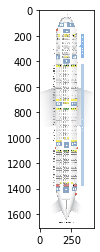

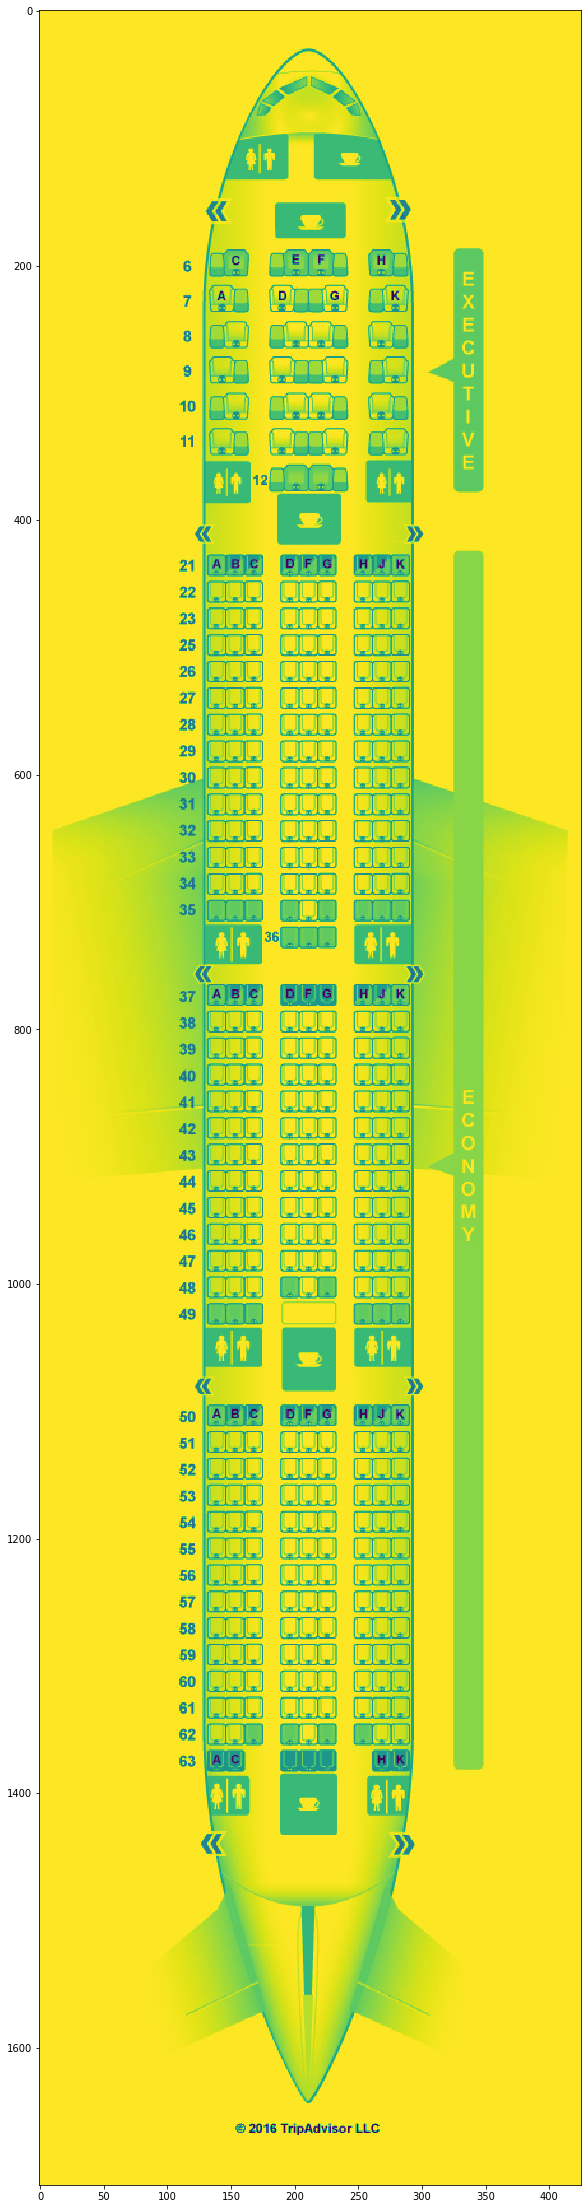

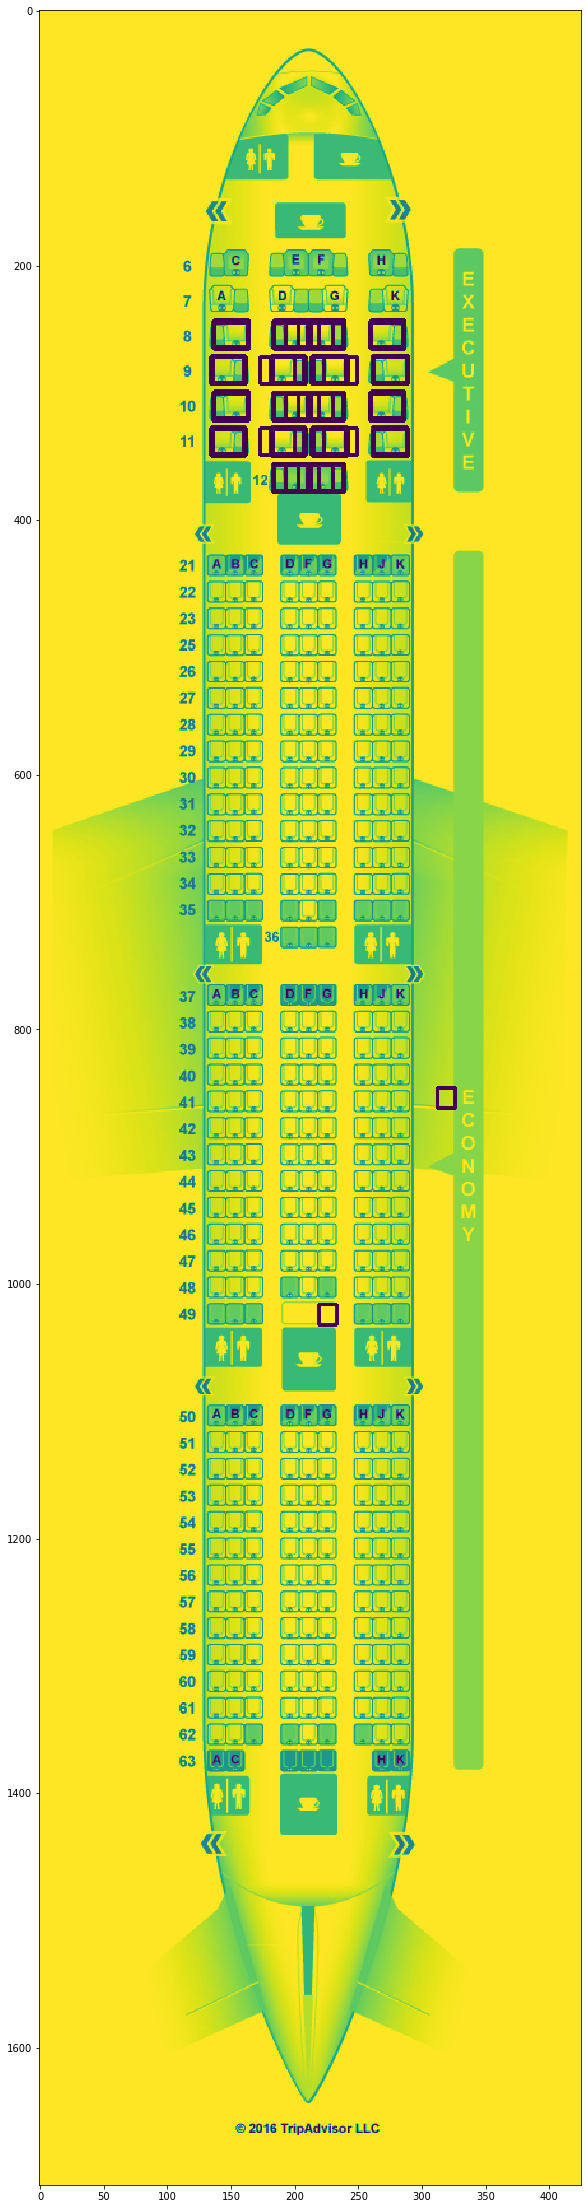

In [7]:
pipeline.run_pipeline(1, templates = ['temp_normal_seat.jpg', 'temp_normal_seat_a.jpg', 'temp_normal_seat_b.jpg', 'temp_normal_seat_c.jpg', 'temp_normal_seat_d.jpg', 'temp_normal_seat_e.jpg', 'temp_normal_seat_elec.jpg', 'temp_normal_seat_f.jpg', 'temp_normal_seat_little.jpg', 'temp_normal_seat_red.jpg','temp_business_seat_armrest_left.jpg', 'temp_business_seat_armrest_right.jpg', 'temp_business_seat_footrest.jpg', 'temp_business_seat_footrest2.jpg', 'temp_business_seat_footrest3.jpg', 'temp_business_turn_left.jpg', 'temp_business_turn_left1.jpg', 'temp_business_turn_right.jpg', 'temp_business_turn_right1.jpg'])

Standard Python >= 3.5 -> preprocess colours a été ajouté.
OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas a été ajouté.
Standard Python >= 3.5 -> preprocess colours
OpenCV4.1.2.30 -> rgb to grey
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Début du pipeline : 
Preprocess :  Standard Python >= 3.5 -> preprocess colours
Doing : Standard Python >= 3.5 -> preprocess colours
Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey
Process :  OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Doing : OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


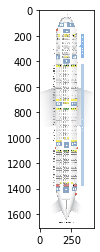

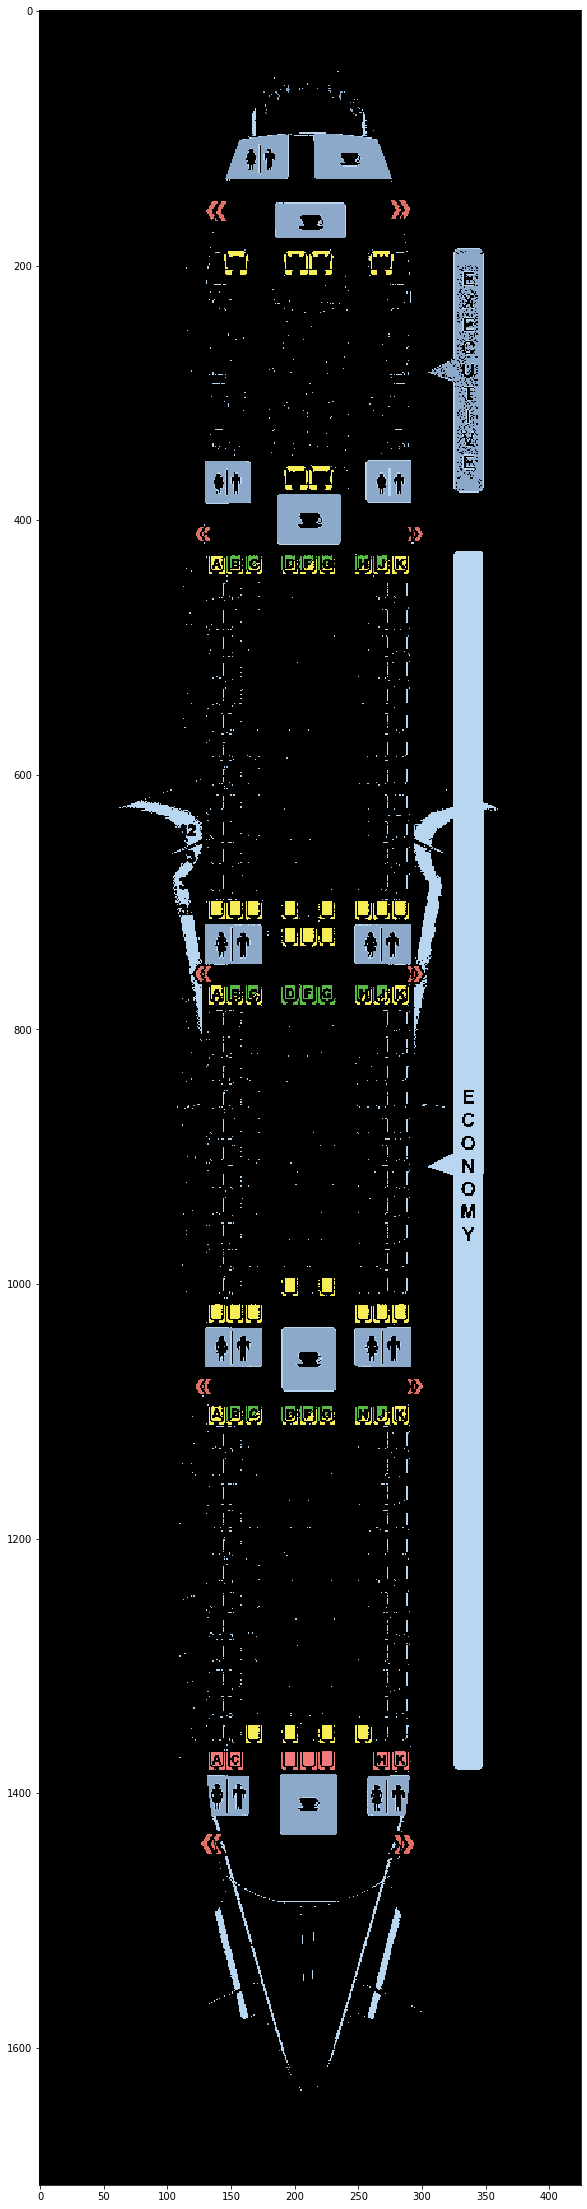

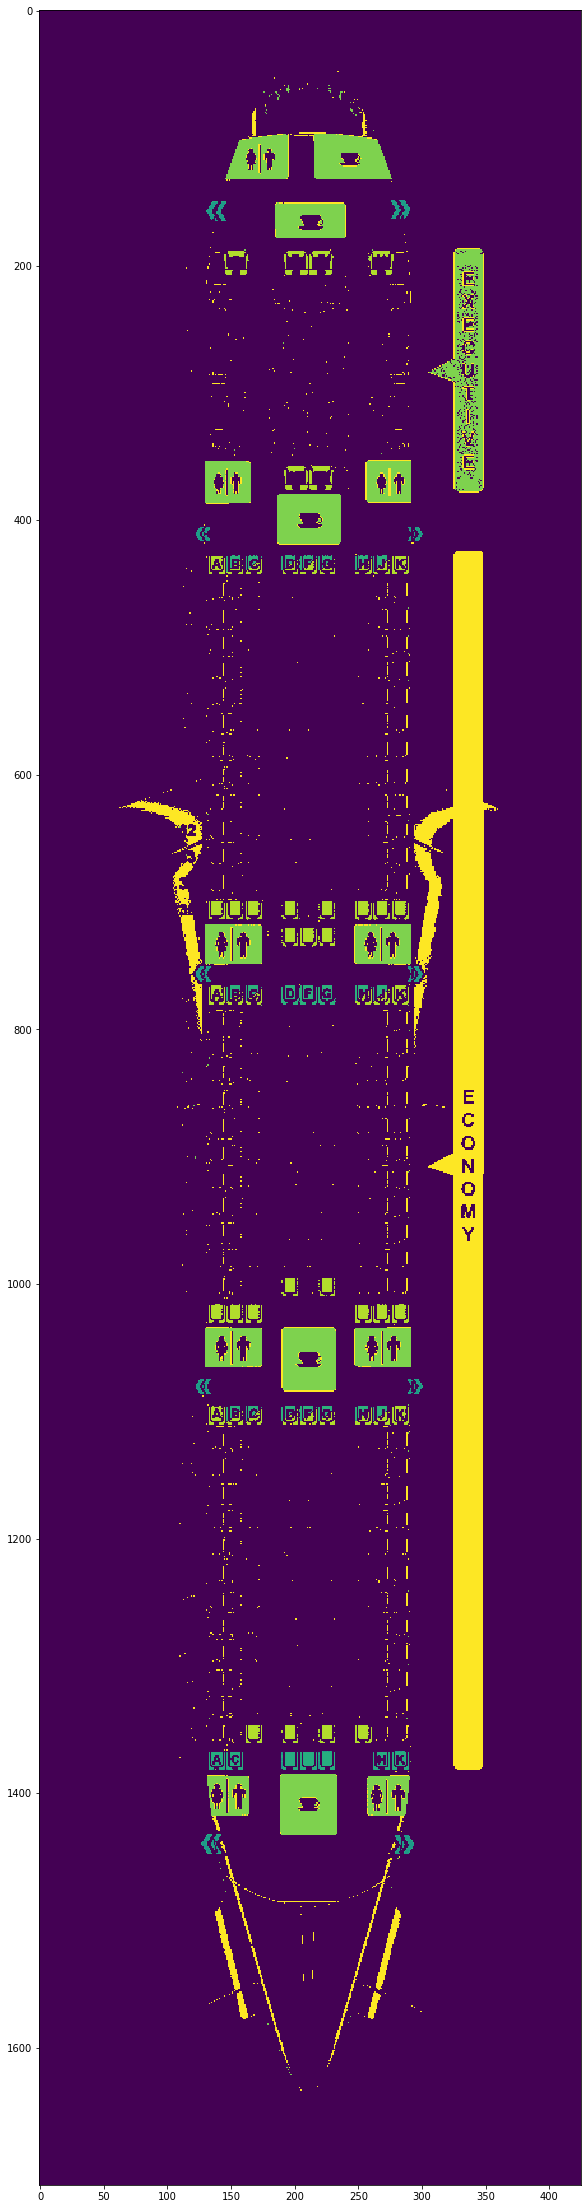

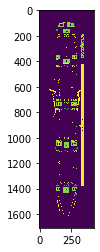

In [8]:
pipeline_zone = Pipeline("/data/git-clone/ProjetInterpromo2020G8/","Oman_Air_Boeing_737-700_new_plane686.jpg")

pipeline_zone.add_processes([ColourPipelineZones, BlackWhite,SegmentationZone])
pipeline_zone.run_pipeline(1)

In [9]:
pipeline_zone.json

{'Garuda_Indonesia_Boeing_777-300ER_V2_plane448.jpg': {'areas': [1422,
   1897,
   1392,
   4502,
   98,
   262,
   107,
   1098,
   1086,
   255,
   1826,
   23584,
   215,
   122,
   282,
   87,
   80,
   120,
   1014,
   307,
   296,
   167,
   147,
   122,
   127,
   628,
   1292,
   1228,
   123,
   290,
   231,
   195,
   141,
   111,
   126,
   95,
   110,
   132,
   135,
   320,
   162,
   305,
   1379,
   1212,
   2013,
   88,
   122,
   249,
   127,
   232,
   152,
   103,
   161,
   117,
   119,
   150,
   280,
   337,
   146,
   144,
   108,
   2041,
   839,
   843,
   326,
   323,
   341,
   337,
   110,
   110],
  'rectangles': [(77, 146, 134, 198),
   (78, 200, 135, 277),
   (151, 185, 179, 241),
   (187, 305, 379, 349),
   (188, 148, 208, 165),
   (188, 192, 209, 229),
   (188, 258, 209, 275),
   (353, 256, 387, 292),
   (354, 130, 388, 166),
   (357, 192, 377, 230),
   (380, 187, 420, 237),
   (425, 294, 1382, 360),
   (428, 131, 443, 160),
   (428, 162, 443, 175),
   

In [10]:
pipeline.json

{'temp_normal_seat.jpg': [],
 'temp_normal_seat_elec.jpg': [],
 'temp_normal_seat_little.jpg': [(312, 846), (219, 1016)],
 'temp_business_seat_armrest_left.jpg': [(137, 243),
  (184, 243),
  (203, 244),
  (214, 271),
  (261, 271),
  (173, 272),
  (137, 299),
  (183, 300),
  (203, 300),
  (214, 327),
  (261, 327),
  (173, 328),
  (183, 356),
  (203, 357)],
 'temp_business_seat_armrest_right.jpg': [(212, 243),
  (260, 243),
  (193, 244),
  (135, 271),
  (182, 271),
  (223, 272),
  (260, 299),
  (193, 300),
  (212, 300),
  (135, 327),
  (182, 327),
  (223, 328),
  (212, 356),
  (193, 357)],
 'temp_business_seat_footrest.jpg': [],
 'temp_business_turn_left.jpg': [],
 'temp_business_turn_right.jpg': []}

In [11]:
dist_pipeline = DistPipeline()
dist_pipeline.run_pipeline(pipeline.json, pipeline_zone.json)

{'Garuda_Indonesia_Boeing_777-300ER_V2_plane448.jpg': {'normal_seat': {},
  'normal_seat_elec': {},
  'normal_seat_little': {((322, 861),
    20,
    30): {'obstacle1': [(172, 105), 770.74], 'obstacle2': [(238, 106),
     759.66], 'obstacle3': [(213, 165), 704.48], 'obstacle4': [(327, 283),
     578.02], 'obstacle5': [(156, 198), 683.47], 'obstacle6': [(210, 198),
     672.39], 'obstacle7': [(266, 198), 665.36], 'obstacle8': [(274, 370),
     493.34], 'obstacle9': [(148, 371), 519.98], 'obstacle10': [(211, 367),
     506.32], 'obstacle11': [(212, 400), 473.94], 'obstacle12': [(327, 903),
     42.3], 'obstacle13': [(145, 435), 461.31], 'obstacle14': [(168, 435),
     452.98], 'obstacle15': [(211, 435), 440.22], 'obstacle16': [(270, 435),
     429.16], 'obstacle17': [(258, 436), 429.79], 'obstacle18': [(283, 436),
     426.79], 'obstacle19': [(95, 662), 301.88], 'obstacle20': [(145, 706),
     235.27], 'obstacle21': [(261, 706), 166.57], 'obstacle22': [(283, 706),
     159.83], 'obstacle